[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ds-reboot/python-first-part/blob/main/notebooks/hometasks/Task3_dmrf_OOP.ipynb)

# Задание
Реализовать с помощью объектно-ориентированного подхода предыдущие 2 задания. Создайте для каждой из задач отдельный класс, который позволяет ее решить.

* Собрать информацию о всех строящихся объектах на сайте "наш.дом.рф"
* Cохранить ее в pandas dataframe, а также в excel, pickle, БД

* Проверить состояние датафрейма и привести его в формат, позволяющий дальнейшее исследование данных

*  Сделать визуализацию для мини-исследования рынка строящейся недвижимости в одном или нескольких регионах с помощью pandas, matplotlib, seaborn, plotly и других инструментов.



In [1]:
import sqlite3
from pathlib import Path
from pprint import pprint
from random import random
from time import sleep

import pandas as pd
import requests
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Defining parameters for url requests
params = {
    'offset': 0,
    'limit': 500,
    'sortField': 'devId.devShortCleanNm',
    'sortType': 'asc',
    'objStatus': 0
}
url = 'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object'
regions_file = 'region_codes.csv'

In [3]:
class DomIdLoader:
    def __init__(self, url, url_params):
        self.url = url
        self.url_params = url_params
        self.objids = []

    def get_ids(self):
        tmp_offset = self.url_params['offset']
        while True:
            with requests.get(self.url, self.url_params) as res:
                print(f"Extracting starting from {self.url_params['offset']}")
                if res.status_code != 200:
                    print(res.status_code)
                    break
                houses = res.json()['data']['list']
                if len(houses) == 0:
                    break
                self.objids.extend([x['objId'] for x in houses])
                self.url_params['offset'] += self.url_params['limit']
                sleep(random())
        print(f'Extracted {len(self.objids)} objects')
        self.url_params['offset'] = tmp_offset

    def show_ids(self, limit=None):
        if limit:
            pprint(self.objids[:limit])
        else:
            pprint(self.objids)

In [4]:
id_loader = DomIdLoader(url, params)
id_loader.get_ids()

Extracting starting from 0
Extracting starting from 500
Extracting starting from 1000
Extracting starting from 1500
Extracting starting from 2000
Extracting starting from 2500
Extracting starting from 3000
Extracting starting from 3500
Extracting starting from 4000
Extracting starting from 4500
Extracting starting from 5000
Extracting starting from 5500
Extracting starting from 6000
Extracting starting from 6500
Extracting starting from 7000
Extracting starting from 7500
Extracting starting from 8000
Extracting starting from 8500
Extracting starting from 9000
Extracting starting from 9500
Extracting starting from 10000
Extracting starting from 10500
Extracting starting from 11000
Extracted 10694 objects


In [5]:
id_loader.show_ids(10)

[29679, 13383, 13397, 13398, 13399, 13391, 36912, 44076, 27476, 10891]


In [42]:
class ObjectInfoExtractor:
    def __init__(self, ids, url):
        self.ids = ids
        self.url = url
        self.house_data = {}
        self.df = None

    def load_data(self):
        for obj in tqdm(self.ids):
            if obj not in self.house_data:
                with requests.get(self.url + '/' + str(obj), verify=False, timeout=10) as res:
                    if res.status_code != 200:
                        print(res.status_code)
                        break
                    self.house_data[obj] = res.json()['data']
                    sleep(random() / 10)

    def df_converter(self):
        self.df = pd.json_normalize(self.house_data.values())
        self.df['photoRenderDTO'] = self.df['photoRenderDTO'].apply(str)
        self.df['objectTransportInfo'] = self.df['objectTransportInfo'].apply(str)
        self.df['metro.colors'] = self.df['metro.colors'].apply(str)

In [16]:
extractor = ObjectInfoExtractor(id_loader.objids, url.replace('kn/', ''))

In [28]:
extractor.load_data()

100%|████████████████████████████████████████████████████████████████████████████| 10694/10694 [05:17<00:00, 33.70it/s]


In [70]:
# Пришлось переделывать класс ObjectInfoExtractor, но чтобы не потерять данные создал новый экземляр
# extractor2 и перекинул туда поле house_data
extractor2 = ObjectInfoExtractor(id_loader.objids, url.replace('kn/', ''))
extractor2.house_data = extractor.house_data
extractor2.df_converter()

In [49]:
class Saver:
    def __init__(self, data):
        self.data = data

    def save_csv(self):
        self.data.to_csv('house_data.csv', index=False)
        
    def save_xl(self):
        self.data.to_excel('house_data.xlsx', index=False)
        
    def save_sql(self):
        with sqlite3.connect('house_data.db') as conn:
            self.data.to_sql(name='houses', con=conn, index=False, if_exists='replace')

In [52]:
saver = Saver(extractor2.df)

In [53]:
saver.save_csv()

In [54]:
saver.save_xl()

In [55]:
saver.save_sql()

In [58]:
class Extractor:
    def __init__(self):
        self.data = None
        
    def get_data(self):
        return self.data
        
    def extract_csv(self):
        self.data = pd.read_csv('house_data.csv')
        return self.data
    
    def extract_xl(self):
        self.data = pd.read_excel('house_data.xlsx')
        return self.data
    
    def extract_sql(self):
        with sqlite3.connect('house_data.db') as conn:
            self.data = pd.read_sql(sql='select * from houses', con=conn)
            return self.data

In [59]:
extr = Extractor()
data = extr.extract_sql()

In [60]:
class Visualizer:
    def __init__(self, data):
        self.data = data
        self.regions = {}
    
    def load_regions(self, file_name):
        with open(file_name, encoding='utf8') as fin:
            fin.readline()
            for line in fin:
                key, value = line.strip().split(';')
                key = int(key)
                value = value.strip('"')
                self.regions[key] = value
    
    def make_full_region(self):
        if self.regions:
            self.data['region_full'] = self.data['region'].apply(lambda x: self.regions[x])
        else:
            print('Please run "load_regions" method first')
    
    def barh_compare_price(self, region1, region2):
        if 'region_full' in self.data.columns:
            df = self.data[['region_full',
                               'objLkClassDesc',
                               'objPriceAvg']].groupby(['region_full', 
                                                        'objLkClassDesc']).mean().unstack()
            df.columns = df.columns.get_level_values(1)
            df.columns.name = None
            fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=2, sharex=True)
            sub_df1 = df.loc[region1, :]
            sub_df2 = df.loc[region2, :]
            sub_df1.plot(ax=axes[0], kind='barh', xlabel='', ylabel='', 
                         title=f'Средняя цена кв. метра {region1}')
            sub_df2.plot(ax=axes[1], kind='barh', xlabel='', ylabel='', 
                         title=f'Средняя цена кв. метра {region2}')
            plt.show()
        else:
            print('Please run "make_full_region" method first')
    
    def plot_build_speed(self, region1, region2):
        if 'region_full' in self.data.columns:
            build_speed = self.data[['region_full', 'id']]
            build_speed['year'] = pd.to_datetime(self.data['objReady100PercDt'], 
                                                 yearfirst=True).dt.year
            df_filter = (build_speed['year'] > 2021) & (build_speed['year'] < 2030)
            build_speed = build_speed[df_filter].groupby(['region_full', 
                                                          'year']).count().reset_index()
            sns.relplot(
                x='year',
                y='id',
                hue='region_full',
                data=build_speed[build_speed['region_full'].isin([region1, region2])],
                kind='line',
                aspect=2
            )
            plt.title('Количество вводимого жилья по годам', size=20)
            plt.show()
        else:
            print('Please run "make_full_region" method first')
    
    def sq_meter_price_hist(self):
        if 'region_full' in self.data.columns:
            means = self.data[['region_full', 'objPriceAvg']].groupby('region_full').mean()
            means.sort_values(by='objPriceAvg').plot(figsize=(6, 15), kind='barh', 
                                                     legend=False, xlabel='', 
                                                     title='Средняя цена кв. метра')
            plt.show()
        else:
            print('Please run "make_full_region" method first')
            
    def pair_compare(self, region1, region2):
        params_mapping = {
            'region_full': 'Регион',
            'floorMax': 'Этажность дома',
            'objFlatCnt': 'Количество квартир',
            'objSquareLiving': 'Жилая площадь',
            'objElemParkingCnt': 'Количество парковочных мест',
            'objPriceAvg': 'цена за квадратный метр'
        }
        df = self.data[[*params_mapping.keys()]].rename(columns=params_mapping)
        df_slice = df[df['Регион'].isin([region1, region2])]
        sns.pairplot(df_slice, hue='Регион', dropna=True)
        plt.show()

In [62]:
visual = Visualizer(extr.extract_sql())

In [63]:
visual.load_regions('region_codes.csv')

In [64]:
visual.make_full_region()

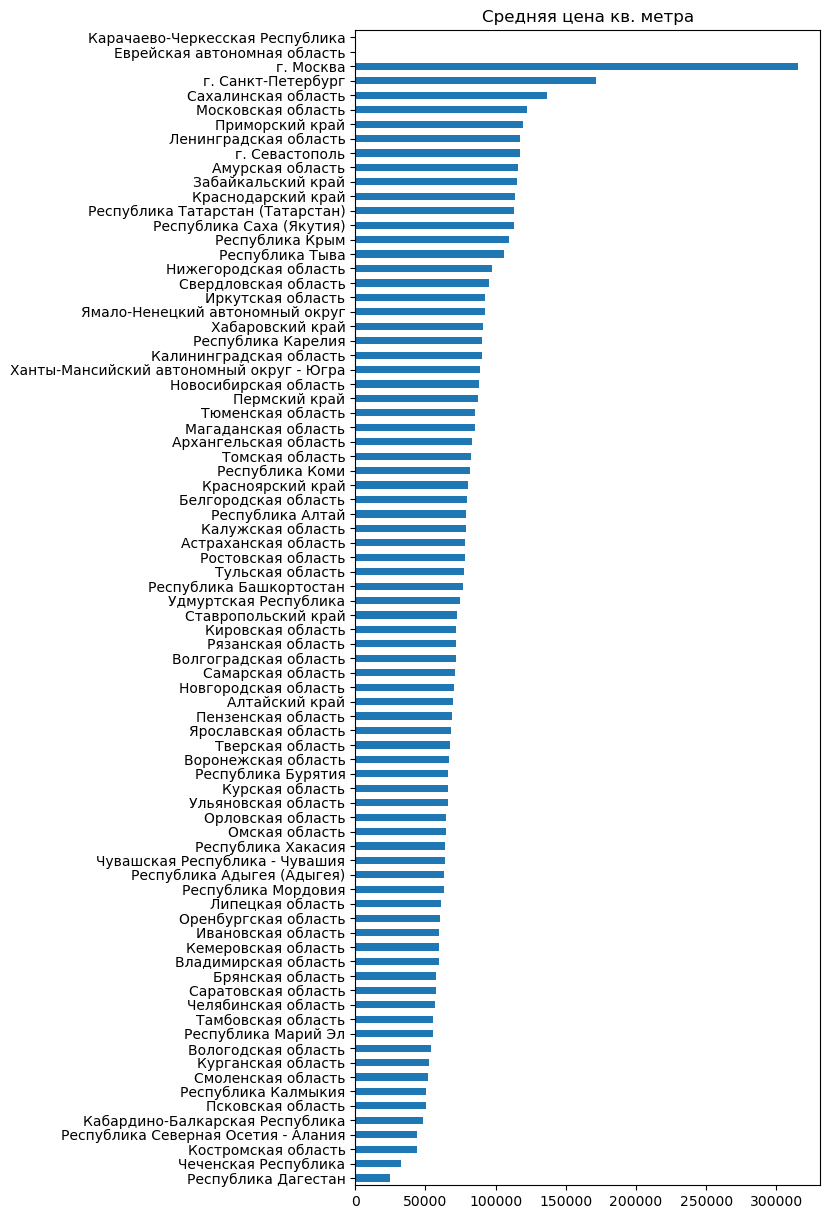

In [65]:
visual.sq_meter_price_hist()

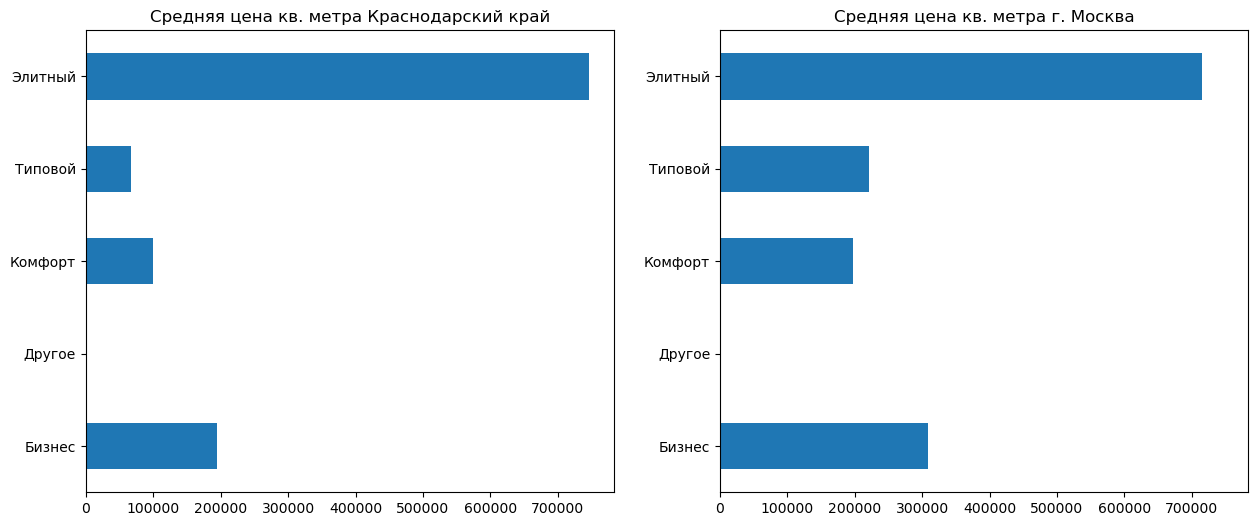

In [66]:
visual.barh_compare_price('Краснодарский край', 'г. Москва')

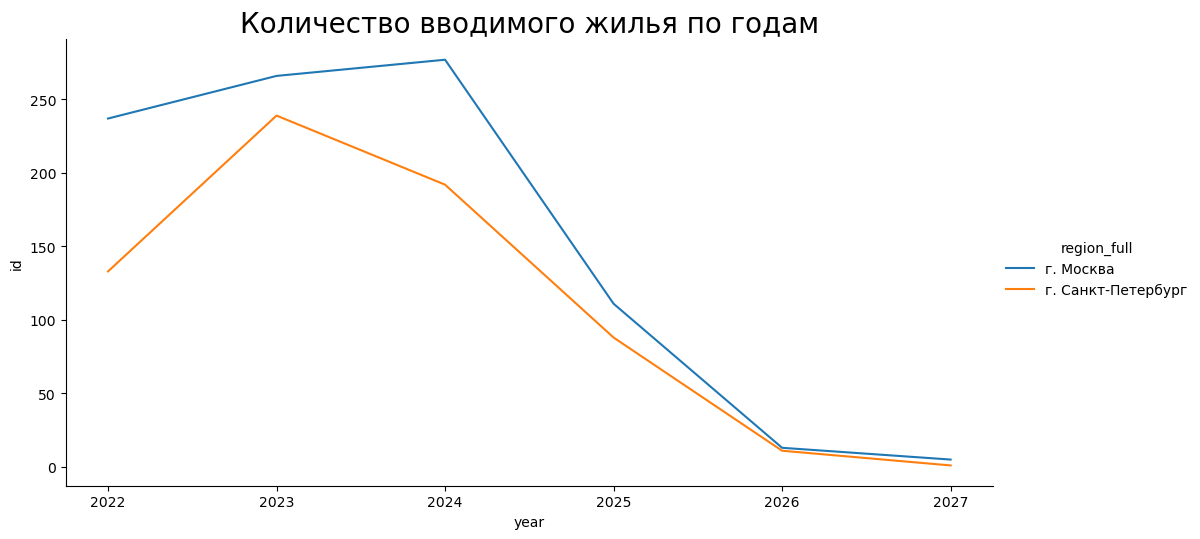

In [67]:
visual.plot_build_speed('г. Москва', 'г. Санкт-Петербург')

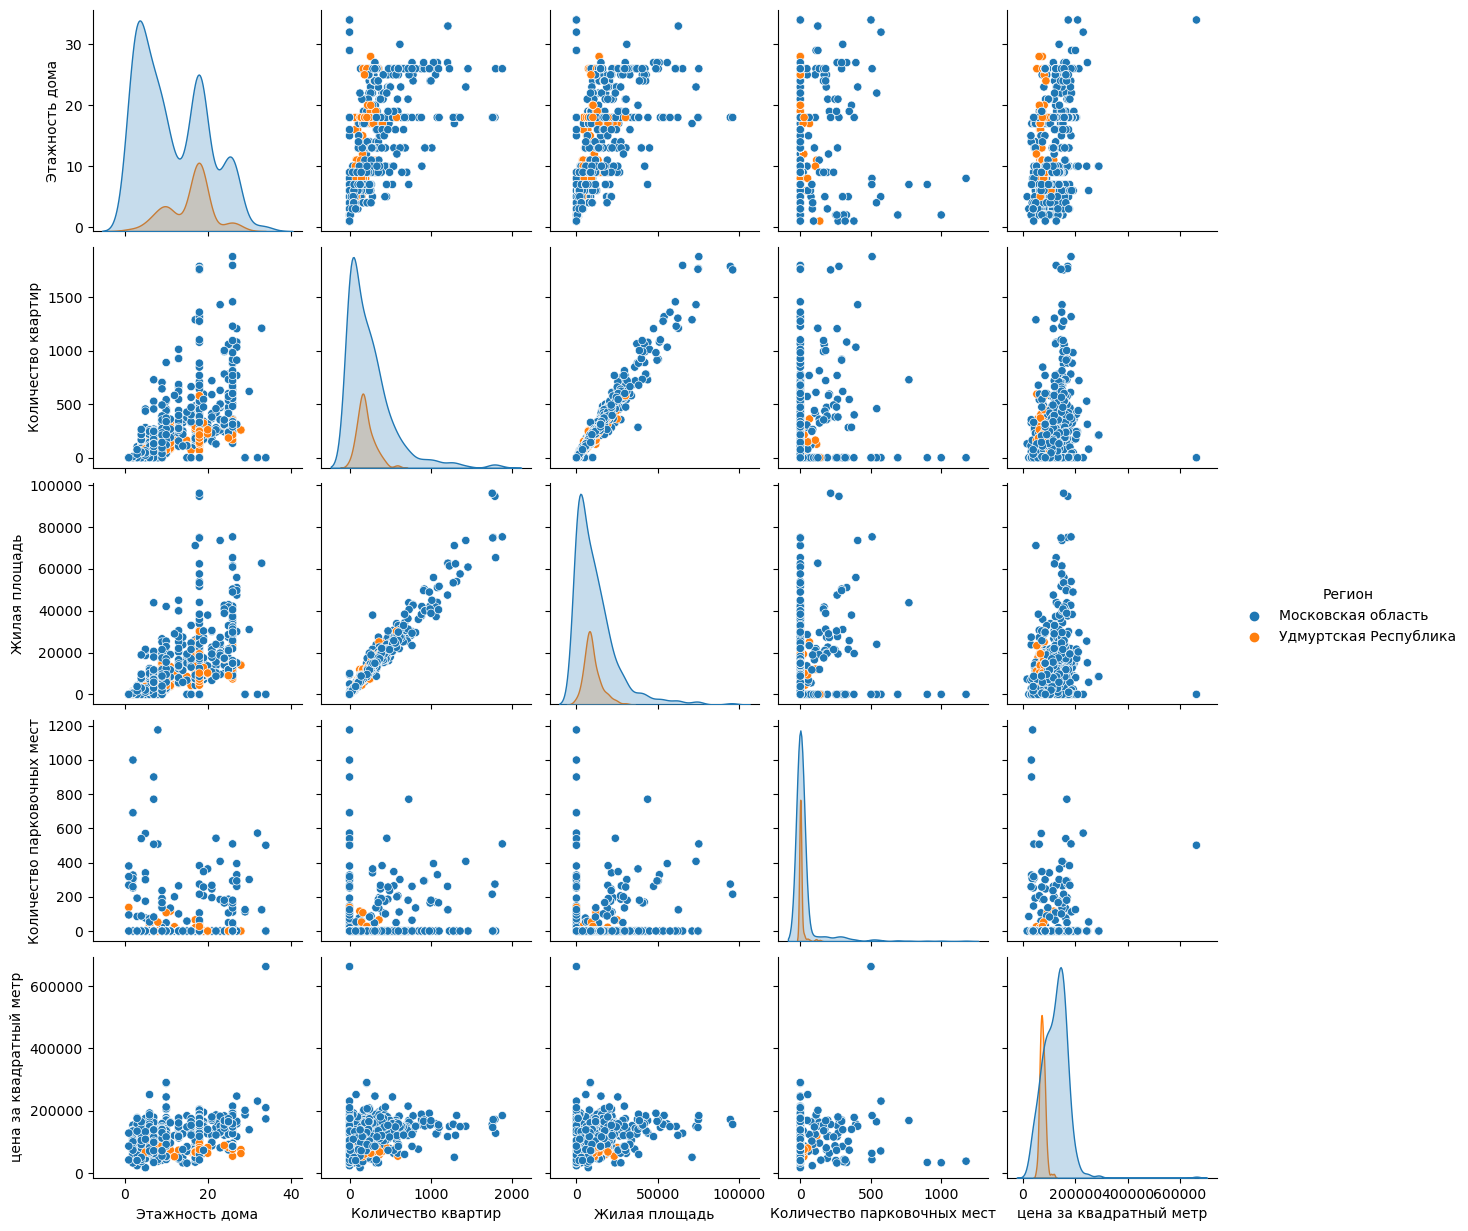

In [68]:
visual.pair_compare('Удмуртская Республика', 'Московская область')